# An introduction to optimal control with Aligator

## Setup

In [43]:
import gepetuto.magic

## Aligator

For this version of the tutorial we will be using Aligator, a new numerical OC library developed by LAAS-CNRS and INRIA Paris.

For this winter school, we have provided an alpha version of the software, under the provisional ame `proxddp`.

In [44]:
import proxddp
import numpy as np
from proxddp import manifolds, dynamics
from utils.bicopter import plotBicopterSolution

----
# Starting example: the unicycle

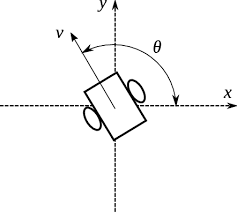

An unicycle represents a kinematic model of a car where it's only possible to move in two directions, i.e. it drives forward and turns on the spot. Its dynamics has nonholonomic constraints because it cannot move sideways. Remember that nonholonomic constraints are nonintegral and has the form $\mathbf{f(q,\dot{q})=0}$.

In this example, we define an optimal-control problem for the classical unicycle problem. Our goal is to drive the unicycle towards the origin but at the same time not too fast. For that, the cost function is described as the sum between the distance to the origin and the system speed.



Basically, our optimal control problem has the following simulation model (ie predicting $x_{next}$ from current state $x$ and control $u$) and cost function:

In [45]:
x = np.random.rand(3)
u = np.random.rand(2)

# Unicycle dynamical model
v,w = u
c,s = np.cos(x[2]),np.sin(x[2])
dt = 1e-2
dx = np.array([ v*c, v*s, w ])
xnext = x + dx*dt

# Cost function: driving to origin (state) and reducing speed (control)
stateWeight = 1
ctrlWeight = 1
costResiduals = np.concatenate([stateWeight*x,ctrlWeight*u])
cost = .5* sum(costResiduals**2)

## Dynamics model


For this basic example, the unicycle model is coded in the library. We will just load it and use it. If you are very curious, have a look! It is in https://github.com/loco-3d/crocoddyl/blob/master/include/crocoddyl/core/actions/unicycle.hxx . We will show you below how a similar model can be developped in Python (easier for prototyping, but far less efficient).

In [70]:
# %load tp3/generated/unicycle_algtr_dynamics
class UnicycleDynamics(dynamics.ExplicitDynamicsModel):
    def __init__(self, timestep):
        space = manifolds.R3()
        super().__init__(space, 2)
        self.dt = timestep

    def forward(self, x, u, data: dynamics.ExplicitDynamicsData):
        c, s = np.cos(x[2]), np.sin(x[2])
        data.xnext[:] = [
            x[0] + c * u[0] * self.dt,
            x[1] + s * u[0] * self.dt,
            x[2] + u[1] * self.dt,
        ]

    def dForward(self, x, u, data: dynamics.ExplicitDynamicsData):
        c, s = np.cos(x[2]), np.sin(x[2])
        data.Jx[:] = np.eye(3)
        data.Jx[0, 2] = -s * u[0] * self.dt
        data.Jx[1, 2] = c * u[0] * self.dt

        data.Ju[0, 0] = c * self.dt
        data.Ju[1, 0] = s * self.dt
        data.Ju[2, 1] = self.dt


The dynamics model contains the description of the system's discrete dynamics, and implements its derivatives.

## Defining the shooting problem
Now we have the action model, let's define the complete problem.
A shooting problem is defined by the initial state from which computing the rollout and a sequence of action models.


In [71]:
# %load tp3/generated/unicycle_algtr_hyperparams
### HYPER PARAMS: horizon and initial state
T = 100
x0 = np.array([-1, -1, 1])


In [103]:
# %load tp3/generated/unicycle_algtr_model
cost_weights = np.array([10.0, 1.0]) ** 2
dt = 0.1
dyn_model = UnicycleDynamics(dt)
rcost = proxddp.QuadraticCost(
    w_x=cost_weights[0] * np.eye(3), w_u=cost_weights[1] * np.eye(2)
)
stage = proxddp.StageModel(rcost, dyn_model)


Here we define a problem starting from $\mathbf{x}_0$ with 20 timesteps (of 0.1 sec by default implementation of unicycle). The terminal action model is defined using the running action model.

In [110]:
# %load tp3/generated/unicycle_algtr_problem
term_cost = rcost.copy()
term_cost.w_x[:] = np.eye(3) * 100.0 ** 2
term_cost.w_u[:] = 0.0

# Define the optimal control problem.
problem = proxddp.TrajOptProblem(x0, [stage] * T, term_cost)


This defines the model, not any algorithm to solve it. The only computation that the problem can provide is to integrate the system for a given sequence of controls.

In [111]:
us = [np.array([1., .1]).T for t in range(T)]
xs = proxddp.rollout(dyn_model, x0, us)

The plotUnicycle function plots the system as two arrows that represent the wheels

(-3.0, 1.0, -2.0, 2.0)

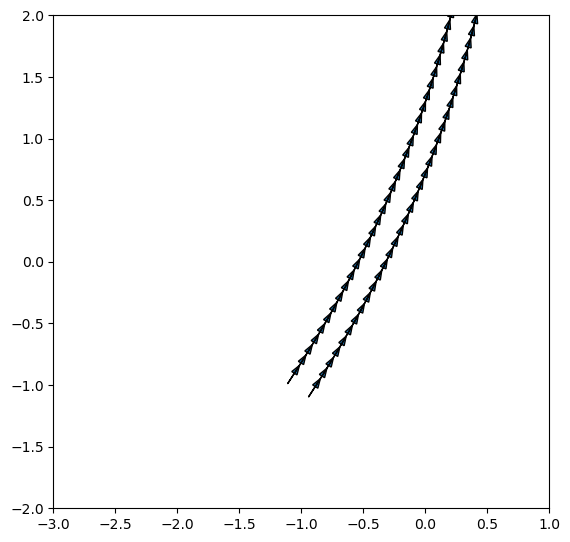

In [112]:
%matplotlib inline
import matplotlib.pylab as plt
from utils.unicycle import plotUnicycleSolution

plotUnicycleSolution(xs)
plt.axis([-3,1.,-2.,2.])

## Solve the OCP
The main solver is named SolverDDP. Other solvers exist, and you can also add other solvers (taken off the shelf, reimplemented from the literature and invented by yourselves). More on this in the second exercise. 

The DDP solver is initialized with the problem object and mostly contains the ddp.solve method. 

In [113]:
# %load tp3/generated/unicycle_algtr_ddp
# Select the solver for this problem
TOL = 1e-6
ddp = proxddp.SolverFDDP(TOL, verbose=proxddp.VERBOSE)
ddp.setup(problem)


We can warm start it and tune the parameters, but for the simple unicycle, let's just solve it:

In [114]:
# %load tp3/generated/unicycle_algtr_solve
done = ddp.run(problem, [], [])
assert done


iter｜  alpha   ｜ prim_err ｜ dual_err ｜   xreg   ｜  dphi0   ｜  merit   ｜ delta_M  ｜aliter｜   mu   
   1｜ 1.000e+00｜ 1.000e+00｜ 1.683e+03｜ 1.000e-09｜-4.292e-12｜ 3.496e+02｜       200
   2｜ 1.000e+00｜ 0.000e+00｜ 2.385e+01｜ 1.000e-09｜-1.982e+02｜ 2.504e+02｜     -99.2
   3｜ 1.000e+00｜ 0.000e+00｜ 1.606e+00｜ 1.000e-09｜-5.747e-01｜ 2.501e+02｜    -0.285
   4｜ 1.000e+00｜ 0.000e+00｜ 1.664e-01｜ 1.000e-09｜-1.496e-02｜ 2.501e+02｜   -0.0072
   5｜ 1.000e+00｜ 0.000e+00｜ 5.216e-02｜ 1.000e-09｜-6.271e-04｜ 2.501e+02｜ -0.000295
   6｜ 1.000e+00｜ 0.000e+00｜ 7.458e-03｜ 1.000e-09｜-2.908e-05｜ 2.501e+02｜ -1.35e-05
   7｜ 1.000e+00｜ 0.000e+00｜ 2.562e-03｜ 1.000e-09｜-1.417e-06｜ 2.501e+02｜ -6.57e-07
   8｜ 1.000e+00｜ 0.000e+00｜ 3.555e-04｜ 1.000e-09｜-7.112e-08｜ 2.501e+02｜  -3.3e-08
   9｜ 1.000e+00｜ 0.000e+00｜ 1.248e-04｜ 1.000e-09｜-3.644e-09｜ 2.501e+02｜ -1.69e-09
  10｜ 1.000e+00｜ 0.000e+00｜ 1.723e-05｜ 1.000e-09｜-1.900e-10｜ 2.501e+02｜ -8.88e-11
  11｜ 1.000e+00｜ 0.000e+00｜ 6.164e-06｜ 1.000e-09｜-1.006e-11｜ 2.501e+02｜ -5.26e-12


Let's plot the result

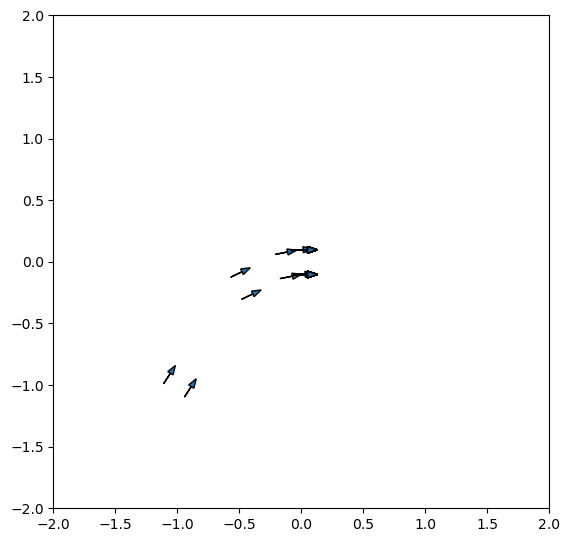

In [115]:
# %load tp3/generated/unicycle_algtr_plot_sol
rs: proxddp.Results = ddp.results
plotUnicycleSolution(rs.xs)


The solver journey is typically plotted like this.

The terminal state chosen by the solver is:

In [68]:
print(rs.xs[-1])

## Well, the terminal state is not so nicely in the origin.

Question 1: why?

Question 2: How can you change this?

Question 3: by changing the cost parameters, the time horizon and the initial position, can you trigger a maneuver?

In [ ]:
%do_not_load_snippet tp1/generated/unicycle_toward_origin_termmodel

----
# Defining your own (bicopter) model

Unicycle is a very basic example. Most interesting problems in robotics are written at the acceleration level to easily convey forces and action-reaction phenomena. We will now consider a bicopter model (i.e. a UAV evolving in a vertical plane). It is composed of two rotors producing pure orthogonal forces, hence leading to linear and angular accelerations resulting from the thrust and gravity effects. 

## Bicopter equations of motion
The bicopter is defined by its mass $m$, wingspan $l$ (distance from the copter center to each propeller), inertia $i=l^2m$ and gravity $g$. The state $x=(q,v)$ is the concatenation of position and velocity of the copter, with $q=(x_1,x_2,\theta)$, $x_1$ the horizontal position, $x_2$ the vertical position and $\theta$ the angle) and  $v=(v_1,v_2,\omega)$ the horizontal, vertical and angle velocities.
The control is the thrust (vertical forces) of right then leg propellers $(u=(f_r, f_l)$).

The linear and angular forces due to the propellers are easy to express in the local frame:
$$f = \left(0, f_r+f_l, (f_l-f_r) l \right)$$
The acceleration in world frame is then obtained by rotating the linear forces, dividing by mass and inertia and adding the gravity:
$$a = \left(\frac{f[1] \sin(\theta)}{m}, \frac{f[1] \cos(\theta)}{m}-g, \frac{f[2]}{i} \right)$$



## Equations of motion

As for the unicyle model, we need to integrate this quantity to get the next state $x_\text{next}$ from the current state $x$ and control $u$. Now, the bicopter is in acceleration, so the integration should be repeated twice (from acceleration to position). We could do that directly in the action model.

In Aligator, we model explicit, continuous-time ODE dynamics with the class `proxddp.dynamics.ODEAbstract`. Unlike Crocoddyl, we make *no assumption that these are second-order dynamics*.
This means the end-user has complete freedom to implement whatever first-order state dynamics they desire.

This also means an implementation of `ODEAbstract` should implement the
$$
  \dot{x} = \begin{bmatrix} \dot{q} \\ \dot{v} \end{bmatrix} =
  \begin{bmatrix} v \\ a(q,v,u)\end{bmatrix}
$$
where $x = (q,v)$.

In discrete-time, the user can call upon one of the `proxddp.dynamics.IntegratorBase` classes, such as `proxddp.dynamics.IntegratorSemiImplicitEuler` (which is the counterpart of `crocoddyl.IntegratorActionModelEuler`). The discrete dynamics of the latter are givn by:
$$v_+ = v + a \Delta t$$
$$q_+ = q + v_+ \Delta t$$
with $\Delta t$ the integration step, defined as a hyperparameter (tune it with the trade-off between numerical accuracy - small $\Delta t$ - and computational efficiency - large $\Delta t$). Note the $v_+$ in the second row: we call that *implicit* Euler integration, and it is marginally more stable.

In numerical optimal control, a convenient class of cost functions is nonlinear sum of squares.
The cost $\ell(x,u)$ is typically defined as:
$$
\ell(x,u) = \frac{1}{2} \| r(x,u) \|_2^2
$$
where $r(x,u)$ is the residual.
This has the practical consequence that we can approximate the Hessian of the cost $H = \nabla^2\ell$ as
$$
  \frac{\partial^2 \ell}{\partial x^2} \approx \frac{\partial r}{\partial x}^T \frac{\partial r}{\partial x}
$$

For the copter, we propose to put quite a lot of terms in $r$ so that you can *play* with many hyperparameters to tune:
$$r=(x_1,x_2,\sin(\theta),1-\cos(\theta),v,u,a) \in \mathbb{R}^{12}$$

## Hyperparameters
The optimal control problem depends on the following parameters.

In [2]:
# %load tp3/generated/bicopter_algtr_hyperparams
### Horizon and initial state
timeStep = 0.01
x0 = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
T = 50
mass = 1.0
span = 0.2
grav = 10.0
costWeights = np.array([
    0.1, # x
    0.1, # z
    .10, # s
    .10, # c
    0.001, # vx
    0.001, # vz
    0.001, # w
    0.0, # fr
    0.0, # fl
    0.001,0.001,0.001, # a
])  # sin, 1-cos, x, xdot, thdot, f
nu = 2
space = manifolds.VectorSpace(6)  # state space


## Defining the residual and dynamics

In [30]:
# %load tp3/generated/bicopter_algtr_state_error
class BicopterStateError(proxddp.StageFunction):
    def __init__(self):
        super().__init__(6, nu, nr=12)

    def evaluate(self, x, u, y, data: proxddp.StageFunctionData):
        x1, x2, th, v1, v2, w = x
        fr, fl = u
        s, c = np.sin(th), np.cos(th)
        # finish implementation here


In [31]:
# %load tp3/generated/bicopter_algtr_ode
class BicopterODE(dynamics.ODEAbstract):
    def __init__(self):
        super().__init__(space, nu)
        self.unone = np.zeros(nu)
        self.inertia = mass * span**2

    def forward(self, x, u, data: dynamics.ODEData):
        # data.xdot must contain the first-order time derivative
        # of the state variable x
        x1, x2, th, v1, v2, w = x
        fr, fl = u
        # finish implementation here


Fill this template by adding your own code. Then create a model object.

In [29]:
# %load tp3/generated/bicopter_algtr_dynamics_and_residual
ode = BicopterODE()
state_err_ = BicopterStateError()


----

### Solution

The following snippet contains the code for the bicopter's acceleration:

In [6]:
%do_not_load_snippet tp3/generated/bicopter_algtr_acc

## Creating the integrator

We feed the ODE into the corresponding numerical integration class.

In [17]:
# %load tp3/generated/bicopter_algtr_integrator
dyn_model_ = dynamics.IntegratorSemiImplEuler(ode, timeStep)  # has no derivatives


## Finite differences

At this point, neither the state error function (which will be used in the cost), nor the discrete dynamics have their derivatives.

We will use 

In [18]:
# %load tp3/generated/bicopter_algtr_finite_difference
# Use the finite-difference helpers from proxddp
# DynamicsFiniteDifferenceHelper, FiniteDifferenceHelper 
fd_eps = 1e-4
dyn_model_nd = proxddp.DynamicsFiniteDifferenceHelper(space, dyn_model_, fd_eps)
state_err_nd = proxddp.FiniteDifferenceHelper(space, state_err_, fd_eps)
# define a quadratic cost from the bicopter state error
rcost = proxddp.QuadraticResidualCost(space, state_err_nd, np.diag(costWeights ** 2 * timeStep))


## Terminal cost model

We suggest you use different weights for the terminal cost

In [26]:
# %load tp3/generated/bicopter_algtr_termmodel
# Terminal cost: same as the runningcost, but we increase the cost weights
# in the library, they're a square matrix you can access through `cost.weights`
term_cost = proxddp.QuadraticResidualCost(space, state_err_nd, np.diag(costWeights ** 2))
_w = np.diagonal(term_cost.weights)
_w.setflags(write=True)
_w[:] = 1e4


## Definition of the optimal control problem
Now, you classically do:

In [28]:
# %load tp3/generated/bicopter_algtr_ocp
stage = proxddp.StageModel(rcost, dyn_model_nd)
problem = proxddp.TrajOptProblem(x0, [stage] * T, term_cost)

TOL = 1e-5
verbosity = proxddp.VERBOSE
solver = proxddp.SolverProxDDP(TOL, max_iters=300, verbose=verbosity)
solver.setup(problem)  # allocate data for this problem
ok = solver.run(problem, [], [])

rs: proxddp.Results = solver.results
print(rs)
xs_opt = rs.xs.tolist()


## Visualize the solution
Plot ...

In [34]:
# %load tp3/generated/bicopter_algtr_plot
plotBicopterSolution(xs_opt)

print('Type plt.show() to display the result.')


If you want, you can see the movement in a 3D visualization. 

In [32]:
# %load tp3/generated/bicopter_algtr_viz
viz = ViewerBicopter()
viz.displayTrajectory(xs_opt, timeStep)


----
# Conclusion
Like the unicycle, you can similarly play with the copter, changing the initial conditions or the weights, which should trigger different maneuvers or even strange behaviors. Remember this is a local optimization solver, which you better warm start with a sound behavior when trying to achieve something fancy.

